In [9]:
import os
import unicodedata
import numpy as np
import pandas as pd
import warnings
import nltk
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer
stemmer = nltk.PorterStemmer()
nltk.download('omw-1.4')
nltk.download('wordnet')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package omw-1.4 to /home/muddy/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /home/muddy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Text Cleaning

<A HREF="https://docs.python.org/3.8/library/unicodedata.html#unicodedata.normalize">About unicodedata.normalize</A>

In [92]:
# Load up the files
#path = './DataUCSB/' # Smaller UCSB dataset
path = './Data/' # larger American Rhetoric dataset
list_of_files = []

dates = pd.read_csv('dateSpeeches.csv')

for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.txt'):
            list_of_files.append(os.path.join(root,file))

speeches = []
for file in list_of_files:
    with open(file, encoding='utf-8') as f:
        text = f.read()
    f.close()
    speeches.append([text, file[7:]])

#clean out goofy unicode  space characters 
speeches = [(unicodedata.normalize("NFKD", speech[0]), speech[1]) for speech in speeches if len(speech)>0 ]

In [121]:
docs = pd.DataFrame(speeches, columns=['content', 'filename']);
docs.head()

,content,filename
0,"Thank you, Governor. To all the families, first responders, to the community of Newtown, clergy,...",barackobamanewtownvigilspeech.txt
1,Selamat pagi. [Good morning.] It is wonderful to be here at the University of Indonesia. To the...,barackobamaindonesiauniversity.txt
2,"First of all, let me thank Dr. [Francis] Collins not just for the introduction but for his incre...",barackobamabraininitiative.txt
3,"Hello, everybody! All right, everybody have a seat. I got a lot to say here. First of all, I ...",barackobamanursesassociation.txt
4,"Good morning, everyone. It is a great honor to be with you here today. Of course, it is a trul...",barackobamanationalholocaustmemorialmuseum.txt


In [122]:
dateinfo = pd.read_csv('AmRhet_date_data.csv')
dateinfo['date'] = pd.to_datetime(dateinfo['date'], format='%d %b %Y')

In [123]:
documents = pd.merge(docs, dateinfo, how='left', on='filename')
documents.sort_values('date', ascending=True, ignore_index=True, inplace=True)

In [138]:
# Save this good clean data!
#documents.to_csv("AmRhet_speeches_with_dates.csv", index=False)

In [139]:
#Build Text-Cleaning Pipeline
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [140]:
word_list = [speech.split() for speech in documents['content']]

In [141]:
#apply pipeline 
processed_docs = documents['content'].map(preprocess)
processed_docs[:10]

0    [good, afternoon, begin, say, bill, anti, ralli, stand, oppos, circumst, civil, bloodiest, histo...
1    [behalf, great, state, illinoi, crossroad, nation, land, lincoln, express, deepest, gratitud, pr...
2    [thank, presid, ladi, gentlemen, senat, anticip, speak, today, import, think, issu, feel, import...
3    [good, morn, presid, taylor, board, truste, faculti, parent, famili, friend, commun, galesburg, ...
4    [presid, today, nation, mourn, genuin, american, hero, know, rosa, park, die, yesterday, home, d...
5    [thank, presid, know, year, follow, devast, attack, histori, bodi, pass, patriot, order, nation,...
6    [thank, presid, today, mourn, pass, ofcoretta, scott, king, think, coretta, scott, king, think, ...
7    [presid, rise, today, humbl, honor, opportun, express, support, renew, expir, provis, thevot, ri...
8    [know, month, think, hard, plan, run, presid, profound, decis, decis, basi, media, hype, person,...
9    [hello, springfield, look, look, good, thank, than

## LDA Model

In [142]:
#Create dictionary
dictionary = gensim.corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below=2, no_above=0.5, keep_n=1000)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [143]:
#Take a look
bow_doc_200 = bow_corpus[200]
for i in range(5):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_200[i][0], 
                                               dictionary[bow_doc_200[i][0]], 
                                     bow_doc_200[i][1]))


Word 8 ("battl") appears 1 time.
Word 9 ("bear") appears 1 time.
Word 13 ("brutal") appears 1 time.
Word 22 ("corpor") appears 2 time.
Word 27 ("cynic") appears 2 time.


In [144]:
%%capture --no-display
#fit in LDA model
from gensim import corpora, models
import numpy as np
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                       num_topics=6, 
                                       id2word=dictionary, 
                                       passes=2, 
                                       workers=2,
                                       random_state=np.random.RandomState(33))

In [145]:
#Take a look of the reasult of topic model
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.006*"iran" + 0.006*"nuclear" + 0.006*"democraci" + 0.005*"terrorist" + 0.005*"muslim" + 0.005*"deal" + 0.005*"human" + 0.005*"intern" + 0.004*"obama" + 0.004*"attack"
Topic: 1 
Words: 0.009*"militari" + 0.008*"iran" + 0.007*"nuclear" + 0.007*"isil" + 0.006*"iraq" + 0.006*"terrorist" + 0.006*"israel" + 0.005*"veteran" + 0.005*"intern" + 0.005*"weapon"
Topic: 2 
Words: 0.008*"obama" + 0.005*"faith" + 0.005*"iraq" + 0.005*"energi" + 0.004*"region" + 0.004*"militari" + 0.004*"nuclear" + 0.004*"folk" + 0.004*"intern" + 0.004*"iran"
Topic: 3 
Words: 0.009*"obama" + 0.008*"republican" + 0.007*"energi" + 0.006*"vote" + 0.006*"deficit" + 0.005*"folk" + 0.005*"parti" + 0.005*"insur" + 0.005*"cost" + 0.005*"compani"
Topic: 4 
Words: 0.012*"insur" + 0.011*"obama" + 0.009*"governor" + 0.009*"compani" + 0.008*"reform" + 0.007*"afford" + 0.006*"folk" + 0.006*"cost" + 0.006*"money" + 0.005*"republican"
Topic: 5 
Words: 0.008*"human" + 0.008*"obama" + 0.006*"school" + 0.005*"develop"

In [146]:
%%capture --no-display
#fits LDA_model_tfidf
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=5, id2word=dictionary, passes=2, workers=4)


In [152]:
#result
for idx, topic in lda_model_tfidf.print_topics():
    print('Topic: {} Word: {}\n'.format(idx, topic))

Topic: 0 Word: 0.010*"insur" + 0.006*"obama" + 0.005*"court" + 0.004*"afford" + 0.003*"republican" + 0.003*"intellig" + 0.003*"governor" + 0.003*"judg" + 0.003*"senat" + 0.003*"check"

Topic: 1 Word: 0.007*"veteran" + 0.004*"deficit" + 0.004*"iraq" + 0.003*"obama" + 0.003*"cut" + 0.003*"troop" + 0.003*"insur" + 0.003*"debt" + 0.003*"militari" + 0.002*"republican"

Topic: 2 Word: 0.003*"obama" + 0.003*"veteran" + 0.003*"insur" + 0.002*"immigr" + 0.002*"treatment" + 0.002*"energi" + 0.002*"africa" + 0.002*"tonight" + 0.002*"compani" + 0.002*"diseas"

Topic: 3 Word: 0.005*"isil" + 0.005*"iran" + 0.004*"nuclear" + 0.004*"israel" + 0.004*"obama" + 0.003*"iraq" + 0.003*"energi" + 0.003*"region" + 0.003*"militari" + 0.003*"terrorist"

Topic: 4 Word: 0.005*"tonight" + 0.004*"black" + 0.004*"insur" + 0.004*"father" + 0.004*"faith" + 0.003*"king" + 0.003*"prayer" + 0.003*"school" + 0.003*"immigr" + 0.003*"church"



## Topics Visualization

In [148]:
#generate Table 1
def format_topics_sentences(ldamodel=None, corpus=bow_corpus, texts=data):    
    sent_topics_df = pd.DataFrame()    
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus, texts=processed_docs)
  #Changes columns name
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.to_csv('df_dominant_topic.csv')
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1,0.7940,"militari, iran, nuclear, isil, iraq, terrorist, israel, veteran, intern, weapon","[good, afternoon, begin, say, bill, anti, ralli, stand, oppos, circumst, civil, bloodiest, histo..."
1,1,5,0.6404,"human, obama, school, develop, democraci, region, civil, china, freedom, citi","[behalf, great, state, illinoi, crossroad, nation, land, lincoln, express, deepest, gratitud, pr..."
2,2,3,0.9174,"obama, republican, energi, vote, deficit, folk, parti, insur, cost, compani","[thank, presid, ladi, gentlemen, senat, anticip, speak, today, import, think, issu, feel, import..."
3,3,3,0.4806,"obama, republican, energi, vote, deficit, folk, parti, insur, cost, compani","[good, morn, presid, taylor, board, truste, faculti, parent, famili, friend, commun, galesburg, ..."
4,4,5,0.9930,"human, obama, school, develop, democraci, region, civil, china, freedom, citi","[presid, today, nation, mourn, genuin, american, hero, know, rosa, park, die, yesterday, home, d..."
...,...,...,...,...,...
457,457,5,0.4843,"human, obama, school, develop, democraci, region, civil, china, freedom, citi","[welcom, white, hous, everybodi, deliv, farewel, address, rel, brief, want, folk, tribut, somebo..."
458,458,5,0.7958,"human, obama, school, develop, democraci, region, civil, china, freedom, citi","[week, travel, chicago, deliv, final, farewel, address, nation, follow, tradit, presid, opportun..."
459,459,3,0.4257,"obama, republican, energi, vote, deficit, folk, parti, insur, cost, compani","[say, come, predecessor, chanc, welcom, white, hous, world, seri, champion, chicago, cub, know, ..."
460,460,2,0.3848,"obama, faith, iraq, energi, region, militari, nuclear, folk, intern, iran","[good, afternoon, everybodi, start, say, sore, tempt, wear, suit, today, press, confer, michel, ..."


In [154]:
df_dominant_topic['date']=documents[['date']]

In [158]:
#visualization of table1
import plotly.express as px
fig3 = px.scatter(df_dominant_topic,
                     x="date", y="Dominant_Topic", size="Topic_Perc_Contrib", color="Dominant_Topic",
                      size_max=10,
                      title="Topic Analysis" )
fig3.show()

In [160]:
#generate Table2
pd.options.display.max_colwidth = 100
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)   
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]
sent_topics_sorteddf_mallet.head(10)


,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.9950,"iran, nuclear, democraci, terrorist, muslim, deal, human, intern, obama, attack","[good, morn, yesterday, updat, american, peopl, immedi, step, take, increas, screen, secur, trav..."
1,1,0.9987,"militari, iran, nuclear, isil, iraq, terrorist, israel, veteran, intern, weapon","[good, morn, rosi, thank, kind, word, see, rosi, basketbal, court, treat, rosi, dear, friend, lo..."
2,2,0.9953,"obama, faith, iraq, energi, region, militari, nuclear, folk, intern, iran","[good, even, inaugur, address, commit, countri, tireless, task, combat, climat, chang, protect, ..."
3,3,0.9993,"obama, republican, energi, vote, deficit, folk, parti, insur, cost, compani","[seat, everybodi, good, morn, think, sens, question, week, term, come, busi, product, year, expe..."
4,4,0.9992,"insur, obama, governor, compani, reform, afford, folk, cost, money, republican","[hillari, clinton, thank, great, pleasur, introduc, speaker, convers, concern, health, care, thi..."
5,5,0.9985,"human, obama, school, develop, democraci, region, civil, china, freedom, citi","[presid, bush, friend, vice, presid, biden, mayor, rawl, chief, spiller, clergi, member, congres..."


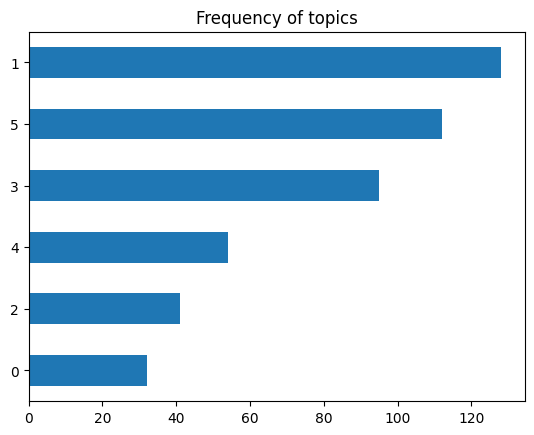

In [161]:
#Frequency Table
import matplotlib.pyplot as plt
df_dominant_topic["Dominant_Topic"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of topics")
plt.show()

[nltk_data] Downloading package stopwords to /home/muddy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


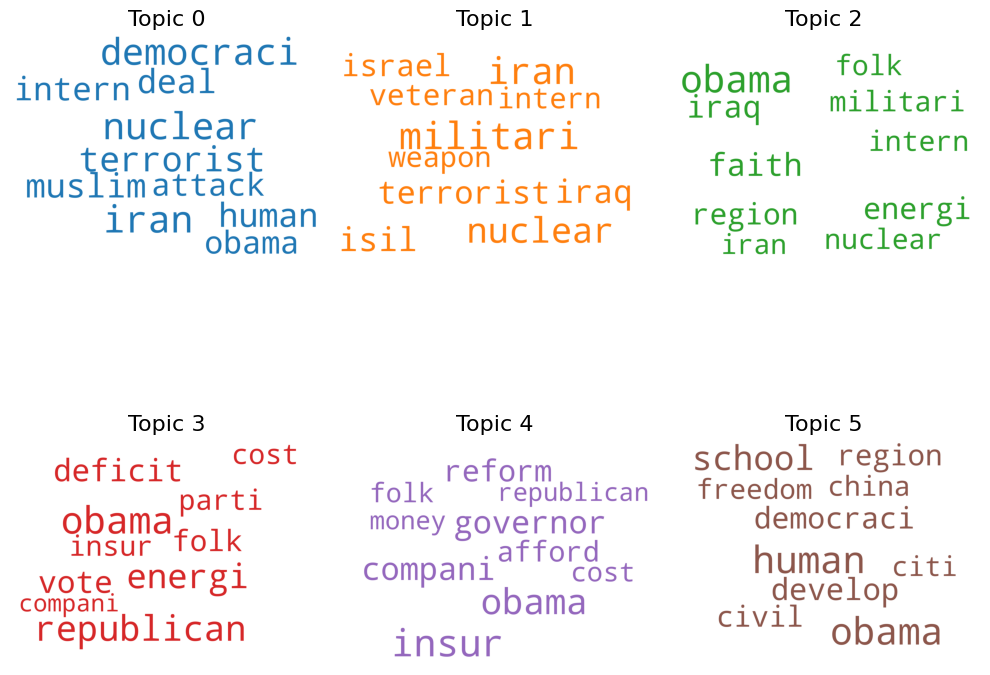

In [162]:
# Wordcloud of Top N words in each topic
warnings.filterwarnings('ignore')
from wordcloud import WordCloud
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = stopwords.words('english')
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)
topics = lda_model.show_topics(formatted=False)
fig, axes = plt.subplots(2, 3, figsize=(10,10), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


In [163]:
%%capture --no-display
!pip install pyLDAvis

In [164]:
#PYLDAvis
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model,bow_corpus,dictionary=lda_model.id2word)
warnings.filterwarnings('ignore')

/home/muddy/.local/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/muddy/.local/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/muddy/.local/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/muddy/.local/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentatio

In [87]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.023535  0.002735       1        1  27.058229
4      0.024394 -0.001081       2        1  23.833769
3      0.000804 -0.017426       3        1  16.599453
2      0.005972  0.023715       4        1  12.090918
0      0.000631 -0.011526       5        1  11.751475
1     -0.008266  0.003583       6        1   8.666155, topic_info=         Term         Freq        Total Category  logprob  loglift
644      iran   823.000000   823.000000  Default  30.0000  30.0000
50   governor   588.000000   588.000000  Default  29.0000  29.0000
658   nuclear   917.000000   917.000000  Default  28.0000  28.0000
764     obama  1735.000000  1735.000000  Default  27.0000  27.0000
293      iraq   762.000000   762.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
581     reduc    61.479493   579.195045   Topic6  -5.8649   0.2028
558     insur    71.520543  1099.710746   Topic6  -5.7137  -0.2871
582    reform    69.467195  1000.748211   Topic6  -5.7428  -0.2219
235    energi    68.024582   954.686551   Topic6  -5.7638  -0.1958
117     small    62.028683   639.836938   Topic6  -5.8560   0.1121

[392 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
149       1  0.228409  activ
149       2  0.213830  activ
149       3  0.140933  activ
149       4  0.223549  activ
149       5  0.126354  activ
...     ...       ...    ...
143       2  0.193056  wound
143       3  0.392547  wound
143       4  0.122269  wound
143       5  0.083658  wound
143       6  0.090093  wound

[1566 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 4, 3, 1, 2])